<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#J1-J2棋盘格模型" data-toc-modified-id="J1-J2棋盘格模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>J1-J2棋盘格模型</a></span></li><li><span><a href="#格点MPO" data-toc-modified-id="格点MPO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>格点MPO</a></span></li><li><span><a href="#MPS正则表示" data-toc-modified-id="MPS正则表示-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MPS正则表示</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#确定边界" data-toc-modified-id="确定边界-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>确定边界</a></span></li><li><span><a href="#能量期望值" data-toc-modified-id="能量期望值-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>能量期望值</a></span></li><li><span><a href="#VUMPS" data-toc-modified-id="VUMPS-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>VUMPS</a></span><ul class="toc-item"><li><span><a href="#单格点" data-toc-modified-id="单格点-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>单格点</a></span></li><li><span><a href="#J1-J2" data-toc-modified-id="J1-J2-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>J1-J2</a></span></li></ul></li><li><span><a href="#程序检验" data-toc-modified-id="程序检验-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>程序检验</a></span><ul class="toc-item"><li><span><a href="#J1-J2-MC" data-toc-modified-id="J1-J2-MC-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>J1-J2 MC</a></span></li><li><span><a href="#bond强度比例-r" data-toc-modified-id="bond强度比例-r-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>bond强度比例 r</a></span></li><li><span><a href="#温度-β" data-toc-modified-id="温度-β-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>温度 β</a></span></li></ul></li></ul></div>

## J1-J2棋盘格模型
横向纵向连接耦合强度为$J_1,J_2$交替排布，形成红色正方形和黑色正方形棋盘格
<img src="figure/29.png" width="40%">

## 格点MPO
权重张量为$M$
<img src="figure/30.png" width="25%">
红色连接上张量为
$\exp(-J_2 h_{ij})$, $J_2 = r J_1$

要收缩的目标张量Z2为
<img src="figure/31.png" width="25%">

能量权重张量为$ME1,ME2$
<img src="figure/32.png" width="25%">

In [71]:
# call library
using LinearAlgebra, TensorOperations, KrylovKit, Random, Statistics, PyPlot, ProgressMeter, Test

In [74]:
# define M,ME1,ME2
function statmechmpo(β, h, D; r = 2.0)
    I = zeros(D,D,D,D)
    for i = 1:D
        I[i,i,i,i] = 1
    end
 
    X1 = zeros(D,D)
    for j = 1:D, i = 1:D
        X1[i,j] = exp(-β*h(i,j))
    end

    X2 = zeros(D,D)
    for j = 1:D, i = 1:D
        X2[i,j] = exp(-β*r*h(i,j))
    end

    X1sq = sqrt(X1)
    X2sq = sqrt(X2)
#     @show X1 X2 X1sq X2sq
    M = Array{Array,2}(undef, 2, 2)
    @tensor MT[a,b,c,d] := I[a',b',c',d']*X1sq[a',a]*X2sq[b',b]*X2sq[c',c]*X1sq[d',d]
    M[1,1] = MT
    M[1,2] = permutedims(MT,[3,2,1,4])
    M[2,1] = permutedims(MT,[1,4,3,2])
    M[2,2] = permutedims(MT,[3,4,1,2])

    # For computing energy: M2 is a tensor across 2 nearest neighbor sites in the lattice, whose
    # expectation value in the converged fixed point of the transfer matrix represents the energy
    Y1 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y1[i,j] = h(i,j)*exp(-β*h(i,j))
    end
    Y2 = zeros(D,D)
    for j = 1:D, i = 1:D
        Y2[i,j] = r*h(i,j)*exp(-β*r*h(i,j))
    end
    
    ME = Array{Array,1}(undef, 2)
    @tensor ME[1][a,b1,b2,c,d2,d1] := I[a',b1',c1,d1']*X2sq[a,a']*X2sq[b1,b1']*X1sq[d1',d1]* Y1[c1,c2]*
                                    I[c2,b2',c',d2']*X2sq[b2,b2']*X2sq[c',c]*X1sq[d2',d2]
    @tensor ME[2][d1,d2,s2,d3,d4,s1] := I[d1',c1,d4',s1']*X1sq[d1,d1']*X2sq[d4',d4]*X1sq[s1',s1]* Y2[c1,c2]*
                                    I[d2',s2',d3',c2]*X1sq[d2,d2']*X1sq[s2',s2]*X2sq[d3',d3]

    λM = norm(M)
    λME = norm(ME)
    return M/λM, ME/λME,λM,λME
end

classicalisingmpo(β; J = 1.0, h = 0.,r = 1.0) = statmechmpo(β, (s1,s2)->-J*(-1)^(s1!=s2) - h/2*(s1==1 + s2==1),
                                                                                            2;r)

classicalisingmpo (generic function with 1 method)

In [75]:
#test
@testset "M ME" begin
    βc = log(1+sqrt(2))/2
    β = 0.1
    M, ME,λM,λME= classicalisingmpo(β; r = 1.0)
    @test M[1,1] ≈ M[1,2] ≈ M[2,1] ≈ M[2,2]
    @test ME[1] != ME[2]
end

Test Summary: | Pass  Total
M ME          |    2      2


Test.DefaultTestSet("M ME", Any[], 2, false)

## MPS正则表示
### 单格点
对于Uniform MPS，在归一化时，边界收缩为
<img src="figure/4.png" width="30%">
从而引入左右正则张量$AL$和$AR$：
<img src="figure/5.png" width="30%">
使得边界收缩掉
<img src="figure/7.png" width="30%">
具体做法为在$A$张量间，左边插入$L^{-1}L$，右边边插入$L^{-1}L$，
<img src="figure/8.png" width="80%">
然后根据周期不变性得到红色方框中的相等的变换关系，并定义$C=LR$
得到
$$L\cdot A\cdot R=AC=AL\cdot C=C \cdot AR$$

### J1-J2
对于A1-A2 MPS，在归一化时，边界收缩为
<img src="figure/9.png" width="40%">
同样引入左正则表示
<img src="figure/10.png" width="40%">
将Uniform形式变换为正则表示，左边插入$L1^{-1}L1L2^{-1}L2$，右边插入$R1R1^{-1}R2R2^{-1}$
<img src="figure/11.png" width="100%">
不同于Uniform形式，$AL1$和$AL2$间多了$L1L2^{-1}$，$AL1$和$AL2$间多了$R1^{-1}R2$，为了收缩能够继续，必须要求
<img src="figure/12.png" width="50%">
再要求为单位矩阵，从而看出虽然不要求中间插入$L1L2^{-1}$和$R1^{-1}R2$为单位矩阵，但是要求$(L2L1^{-1})^{\dagger}L2L1^{-1}$=1，即$L2L1^{-1}$为幺正矩阵

定义$C1=L1R2$和$C2=L2R1$，可以推得
$$AL2\cdot C2 = C1 \cdot AR2$$
$$AL1\cdot C1 = C2 \cdot AR1$$
要求为
$$A2\cdot R2 \cdot R1^{-1} = L1^{-1}\cdot L2 \cdot A2$$
$$A1\cdot R1 \cdot R2^{-1} = L2^{-1}\cdot L1 \cdot A1$$

In [69]:
# function to get AL and AR
safesign(x::Number) = iszero(x) ? one(x) : sign(x)

"""
    qrpos(A)

Returns a QR decomposition, i.e. an isometric `Q` and upper triangular `R` matrix, where `R`
is guaranteed to have positive diagonal elements.
"""
qrpos(A) = qrpos!(copy(A))
function qrpos!(A)
    F = qr!(A)
    Q = Matrix(F.Q)
    R = F.R
    phases = safesign.(diag(R))
    rmul!(Q, Diagonal(phases))
    lmul!(Diagonal(conj!(phases)), R)
    return Q, R
end

"""
    lqpos(A)

Returns a LQ decomposition, i.e. a lower triangular `L` and isometric `Q` matrix, where `L`
is guaranteed to have positive diagonal elements.
"""
lqpos(A) = lqpos!(copy(A))
function lqpos!(A)
    F = qr!(Matrix(A'))
    Q = Matrix(Matrix(F.Q)')
    L = Matrix(F.R')
    phases = safesign.(diag(L))
    lmul!(Diagonal(phases), Q)
    rmul!(L, Diagonal(conj!(phases)))
    return L, Q
end

function cellones(Ni,Nj,D)
    Cell = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        Cell[i,j] = Matrix{Float64}(I, D, D)
    end
    return Cell
end

function ρmap(ρ,Ai,J)
    Nj = size(Ai,1)
    X = Array{Array,1}(undef, Nj+1)
    X[1] = ρ
    for j = 1:Nj
        jr = J+j-1 - (J+j-1 > Nj)*Nj
        @tensor X[j+1][a,b] := X[j][a',b']*Ai[jr][b',s,b]*
            conj(Ai[jr][a',s,a])
    end
    return X[Nj+1]
end
        
"""
    getL(ρ; kwargs...)
    ┌ A1─A2─    ┌       L ─
    ρ │  │    = ρ   =  │
    ┕ A1─A2─    ┕       L'─
ρ=L'*L, return L, where `L`is guaranteed to have positive diagonal elements.
L = cholesky!(ρ).U
If ρ is not exactly positive definite, cholesky will fail
"""
function getL!(A,L; kwargs...)
    Ni,Nj = size(A)
#     L = Array{Array,2}(undef, Ni, Nj)
    D = size(A[1,1],1)
    for i = 1:Ni,j = 1:Nj
        _,ρs,_ = eigsolve(ρ->ρmap(ρ,A[i,:],j), L[i,j]'*L[i,j], 1, :LM; ishermitian = false, maxiter = 1, kwargs...)
        ρ = ρs[1] + ρs[1]'
        ρ ./= tr(ρ)
        F = svd!(ρ)
        Lo = lmul!(Diagonal(sqrt.(F.S)), F.Vt)
        _, L[i,j] = qrpos!(Lo)
    end
    return L
end

"""
    getAL(A)

Given an MPS tensor `A` and `L` ，return a left-canonical MPS tensor `AL`, a gauge transform `R` and
a scalar factor `λ` such that ``λ AR R = L A``
"""
function getAL(A,L)
    Ni,Nj = size(A)
    AL = Array{Array,2}(undef, Ni, Nj)
    Le = Array{Array,2}(undef, Ni, Nj)
    λ = zeros(Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        D, d, = size(A[1,1])
        Q, R = qrpos!(reshape(L[i,j]*reshape(A[i,j], D, d*D), D*d, D))
        AL[i,j] = reshape(Q, D, d, D)
        λ[i,j] = norm(R)
        Le[i,j] = rmul!(R, 1/λ[i,j])
    end
    return AL, Le,λ
end

function Lmap(L, A, AL)
    @tensor X[a,b] := L[a',b']*A[b',s,b]*conj(AL[a',s,a])
end

function getLsped(Le, A, AL; kwargs...)
    Ni,Nj = size(A)
    L = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        λs, Ls, _ = eigsolve(X->Lmap(X, A[i,j], AL[i,j]), Le[i,j], 1, :LM; ishermitian = false, kwargs...)
        _, L[i,j] = qrpos!(Ls[1])
    end
    return L
end

"""
    leftorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a left-canonical MPS tensor `AL`, a gauge transform `C` and
a scalar factor `λ` such that ``λ AL L = L A``, where an initial guess for `C` can be
provided.
"""
function leftorth(A,L=cellones(size(A,1),size(A,2),size(A[1,1],1)); tol = 1e-12, maxiter = 100, kwargs...)
    L = getL!(A,L; kwargs...)
    AL,Le,λ= getAL(A,L;kwargs...)
    numiter = 1
    while norm(L.-Le) > tol && numiter < maxiter
        L = getLsped(Le, A, AL; kwargs...)
        AL,Le,λ= getAL(A, L; kwargs...)
        numiter += 1
    end
    L = Le
    return AL, L,λ
end

"""
    rightorth(A, [C]; kwargs...)

Given an MPS tensor `A`, return a gauge transform C, a right-canonical MPS tensor `AR`, and
a scalar factor `λ` such that ``λ C AR^s = A^s C``, where an initial guess for `C` can be
provided.
"""
function rightorth(A,L=cellones(size(A,1),size(A,2),size(A[1,1],1)); tol = 1e-12, maxiter = 100, kwargs...)
    Ni,Nj = size(A)
    Ar = Array{Array,2}(undef, Ni, Nj)
    Lr = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        Ar[i,j] = permutedims(A[i,j],(3,2,1))
        Lr[i,j] = permutedims(L[i,j],(2,1))
    end
    AL, L,λ = leftorth(Ar,Lr; tol = tol, kwargs...)
    R = Array{Array,2}(undef, Ni, Nj)
    AR = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        R[i,j] = permutedims(L[i,j],(2,1))
        AR[i,j] = permutedims(AL[i,j],(3,2,1))
    end
    return R, AR,λ
end


rightorth

In [135]:
#orth test
@testset "orth  with ($Ni $Nj)" for Ni in [1,2,3], Nj in [1,2,3]
    D = 10
    A = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234+i+j)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    AL, L ,λL = leftorth(A)
    R, AR,λR = rightorth(A,L)
    for i = 1:Ni,j = 1:Nj
        @tensor AL2[b, c] := AL[i,j][a,s,b]*conj(AL[i,j][a,s,c])
        @test Array(AL2) ≈ I(D)
        @tensor AR2[b, c] := AR[i,j][b,s,a]*conj(AR[i,j][c,s,a])
        @test Array(AR2) ≈ I(D)
        
        @tensor ALL[a,s,c] := AL[i,j][a,s,b]*L[i,j][b,c]
        @tensor LA[a,s,c] := L[i,j][a,b]*A[i,j][b,s,c]
        @test LA ≈ ALL * λL[i,j]
        
        @tensor RAR[a,s,c] := R[i,j][a,b]*AR[i,j][b,s,c]
        @tensor A_R[a,s,c] := A[i,j][a,s,b]*R[i,j][b,c]
        @test A_R ≈ RAR * λR[i,j]
#         L_2 = ρmap(L[i,j]' * L[i,j], A[i,:], j)
#         @test std(L_2./(L[i,j]' * L[i,j])) ≈ 0 atol=1e-10
    end
end

Test Summary:    | Pass  Total
orth  with (1 1) |    4      4
Test Summary:    | Pass  Total
orth  with (1 2) |    8      8
Test Summary:    | Pass  Total
orth  with (1 3) |   12     12
Test Summary:    | Pass  Total
orth  with (2 1) |    8      8
Test Summary:    | Pass  Total
orth  with (2 2) |   16     16
Test Summary:    | Pass  Total
orth  with (2 3) |   24     24
Test Summary:    | Pass  Total
orth  with (3 1) |   12     12
Test Summary:    | Pass  Total
orth  with (3 2) |   24     24
Test Summary:    | Pass  Total
orth  with (3 3) |   36     36


9-element Array{Any,1}:
 Test.DefaultTestSet("orth  with (1 1)", Any[], 4, false)
 Test.DefaultTestSet("orth  with (1 2)", Any[], 8, false)
 Test.DefaultTestSet("orth  with (1 3)", Any[], 12, false)
 Test.DefaultTestSet("orth  with (2 1)", Any[], 8, false)
 Test.DefaultTestSet("orth  with (2 2)", Any[], 16, false)
 Test.DefaultTestSet("orth  with (2 3)", Any[], 24, false)
 Test.DefaultTestSet("orth  with (3 1)", Any[], 12, false)
 Test.DefaultTestSet("orth  with (3 2)", Any[], 24, false)
 Test.DefaultTestSet("orth  with (3 3)", Any[], 36, false)

## 确定边界
<img src="figure/13.png" width="30%"/><img src="figure/19.png" width="30%"/>

In [132]:
# function to get FL1 ,FL2 and FR1,FR2
function FLmap3(ALi,ALip, Mi, FL,J)
    Nj = size(ALi,1)
    X = Array{Array,1}(undef, Nj+1)
    X[1] = FL
    for j=1:Nj
        jr = J+j-1 - (J+j-1 > Nj)*Nj
        @tensor X[j+1][α,a,β] := X[j][α',a',β']*ALi[jr][β',s',β]*Mi[jr][a',s,a,s']*conj(ALip[jr][α',s,α])
    end
    return X[Nj+1]
end

function FRmap3(ARi,ARip, Mi, FR,J)
    Nj = size(ARi,1)
    X = Array{Array,1}(undef, Nj+1)
    X[1] = FR
    for j=1:Nj
        jr = J+j-1 - (J+j-1 > Nj)*Nj
        @tensor X[j+1][α,a,β] := ARi[jr][α,s',α']*X[j][α',a',β']*Mi[jr][a,s,a',s']*conj(ARip[jr][β,s,β'])
    end
    return X[Nj+1]
end

function FLmap4(ALi, ALip, Mi, Mip, FL, J)
    Nj = size(ALi,1)
    X = Array{Array,1}(undef, Nj+1)
    X[1] = FL
    for j=1:Nj
        jr = J+j-1 - (J+j-1 > Nj)*Nj
        @tensor X[j+1][α,a,b,β] := X[j][α',a',b',β']*ALi[jr][β',s',β]*Mip[jr][a',s,a,c]*Mi[jr][b',c,b,s']*conj(ALip[jr][α',s,α])
    end
    return X[Nj+1]
end

function FRmap4(ARi, ARip, Mi, Mip, FR, J)
    Nj = size(ARi,1)
    X = Array{Array,1}(undef, Nj+1)
    X[1] = FR
    for j=1:Nj
        jr = J+j-1 - (J+j-1 > Nj)*Nj
        @tensor X[j+1][α,a,b,β] := ARi[jr][α,s',α']*X[j][α',a',b',β']*Mi[jr][a,s,a',s']*Mip[jr][b,c,b',s]*conj(ARip[jr][β,c,β'])
    end
    return X[Nj+1]
end

function F3int(Ni,Nj,D,d)
    F3 = Array{Array,2}(undef, Ni, Nj)
    for i=1:Ni, j=1:Nj
        F3[i,j] = randn(Float64, D, d, D)
    end
    return F3
end

function F4int(Ni,Nj,D,d)
    F4 = Array{Array,2}(undef, Ni, Nj)
    for i=1:Ni, j=1:Nj
        F4[i,j] = randn(Float64, D, d, d, D)
    end
    return F4
end
    
"""
    leftenv(A, M, FL; kwargs)

Compute the left environment tensor for MPS A and MPO M, by finding the left fixed point
of A - M - conj(A) contracted along the physical dimension.
"""
function env3(AL,AR, M, FL = F3int(size(AL,1),size(AL,2),size(AL[1,1],1),size(M[1,1],1)),
                    FR = F3int(size(AR,1),size(AR,2),size(AR[1,1],1),size(M[1,1],1)); kwargs...)
    Ni,Nj = size(AL)
    λFL = zeros(Ni,Nj) + im * zeros(Ni,Nj)
    λFR = zeros(Ni,Nj) + im * zeros(Ni,Nj)
    for i=1:Ni,j=1:Nj
        ir = i + 1 - Ni * (i==Ni)
        λL1s, FL1s, = eigsolve(X->FLmap3(AL[i,:], AL[ir,:], M[i,:], X,j), FL[i,j-1 + (j==1)], 1, :LM; ishermitian = false, kwargs...)
        FL[i,j] = FL1s[1]
        λFL[i,j] = λL1s[1]
        λR1s, FR1s, = eigsolve(X->FRmap3(AR[i,:], AR[ir,:], M[i,:], X,j), FR[i,j-1 + (j==1)], 1, :LM; ishermitian = false, kwargs...)
        FR[i,j] = FR1s[1]
        λFR[i,j] = λR1s[1]
    end
    return FL,FR,λFL,λFR
end

function env4(AL,AR, M, FL = F4int(size(AL,1),size(AL,2),size(AL[1,1],1),size(M[1,1],1)),
                    FR = F4int(size(AR,1),size(AR,2),size(AR[1,1],1),size(M[1,1],1)); kwargs...)
    Ni,Nj = size(AL)
    λFL = zeros(Ni,Nj) + im * zeros(Ni,Nj)
    λFR = zeros(Ni,Nj) + im * zeros(Ni,Nj)
    for i=1:Ni,j=1:Nj
        ir = i + 1 - Ni * (i==Ni)
        irr = i + 2 - Ni * (i+2>Ni) - (Ni==1)
        λL1s, FL1s, = eigsolve(X->FLmap4(AL[i,:], AL[irr,:], M[i,:], M[ir,:], X, j), FL[i,j-1 + (j==1)], 1, :LM; ishermitian = false, kwargs...)
        FL[i,j] = FL1s[1]
        λFL[i,j] = λL1s[1]
        λR1s, FR1s, = eigsolve(X->FRmap4(AR[i,:], AR[irr,:], M[i,:], M[ir,:], X, j), FR[i,j-1 + (j==1)], 1, :LM; ishermitian = false, kwargs...)
        FR[i,j] = FR1s[1]
        λFR[i,j] = λR1s[1]
    end
    return FL,FR,λFL,λFR
end


env4 (generic function with 3 methods)

In [133]:
#ene test
@testset "ene  with ($Ni $Nj)" for Ni in [1,2], Nj in [1,2]
    β = 0.1
    M, ME,λM,λME= classicalisingmpo(β; r = 1.0)
    D = 10
    A = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234+i+j)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    AL, L ,λL = leftorth(A)
    R, AR,λR = rightorth(A,L)
    FL3,FR3,λFL3,λFR3 = env3(AL,AR, M)
    FL4,FR4,λFL4,λFR4 = env4(AL,AR, M)
    for i = 1:Ni,j = 1:Nj
        ir = i + 1 - Ni * (i==Ni)
        irr = i + 2 - Ni * (i+2>Ni) - (Ni==1)
        XL3 = FLmap3(AL[i,:], AL[ir,:], M[i,:], FL3[i,j],j)
        @test XL3 ≈ FL3[i,j] * λFL3[i,j]
        XR3 = FRmap3(AR[i,:], AR[ir,:], M[i,:], FR3[i,j],j)
        @test XR3 ≈ FR3[i,j] * λFR3[i,j]
        XL4 = FLmap4(AL[i,:], AL[irr,:], M[i,:],M[ir,:], FL4[i,j],j)
        @test XL4 ≈ FL4[i,j] * λFL4[i,j]
        XR4 = FRmap4(AR[i,:], AR[irr,:], M[i,:],M[ir,:], FR4[i,j],j)
        @test XR4 ≈ FR4[i,j] * λFR4[i,j]
    end
end

Test Summary:   | Pass  Total
ene  with (1 1) |    4      4
Test Summary:   | Pass  Total
ene  with (1 2) |    8      8
Test Summary:   | Pass  Total
ene  with (2 1) |    8      8
Test Summary:   | Pass  Total
ene  with (2 2) |   16     16


4-element Array{Any,1}:
 Test.DefaultTestSet("ene  with (1 1)", Any[], 4, false)
 Test.DefaultTestSet("ene  with (1 2)", Any[], 8, false)
 Test.DefaultTestSet("ene  with (2 1)", Any[], 8, false)
 Test.DefaultTestSet("ene  with (2 2)", Any[], 16, false)

## 能量期望值
<img src="figure/15.png" width="70%">
<img src="figure/20.png" width="70%">

In [146]:
# function to get energy
function energy(M, ME, AL, C, AR, FL3,FL4, FR3, FR4,λM,λME)
    @tensor AAC1[α,s1,s2,β] := AL[1,2][α,s1,α']*C[1,2][α',β']*AR[1,1][β',s2,β]
    @tensor AAC2[α,s1,s2,β] := AL[2,2][α,s1,α']*C[2,2][α',β']*AR[2,1][β',s2,β]
    @tensor AC1[β,s,β'] := AL[1,1][β,s,d1]*C[1,1][d1,β']
    @tensor Z21 = scalar(FL3[1,2][α,c,β]*AAC1[β,s1,s2,β']*M[1,2][c,t1,d,s1]*
        M[1,1][d,t2,c',s2]*FR3[1,1][β',c',α']*conj(AAC2[α,t1,t2,α']))
    @tensor Z22 = scalar(FL4[1,1][α,a,b,β]*AC1[β,s,β']*M[2,1][b,c,b',s]*
        M[1,1][a,s',a',c]*FR4[1,1][β',b',a',α']*conj(AC1[α,s',α']))

#     @show Z21 Z22
    @tensor e1 = scalar(FL3[1,2][α,c,β]*AAC1[β,s1,s2,β']*ME[1][c,t1,t2,c',s2,s1]*
        FR3[1,1][β',c',α']*conj(AAC1[α,t1,t2,α']) / Z21)
    @tensor e2 = scalar(FL4[1,1][α,a,b,β]*AC1[β,s,β']*ME[2][b,a,s',a',b',s]*
        FR4[1,1][β',b',a',α']*conj(AC1[α,s',α']) / Z22)
#     @show e1 e2 e3 e4
    return e1/λM^2*λME,e2/λM^2*λME
#     return e1,e2,e3,e4
end

energy (generic function with 1 method)

In [149]:
#energy test 
@testset "energy test" begin
    β = 0.1
    M, ME,λM,λME= classicalisingmpo(β; r = 1.0)
    Ni = 2
    Nj = 2
    D = 50
    A = Array{Array,2}(undef, Ni, Nj)
    for i = 1:Ni,j = 1:Nj
        Random.seed!(1234)
        A[i,j] = randn(D, 2, D) + im*randn(D, 2, D)
    end
    AL, L ,λL = leftorth(A)
    R, AR,λR = rightorth(A,L)
    FL3,FR3,λFL3,λFR3 = env3(AL,AR, M)
    FL4,FR4,λFL4,λFR4 = env4(AL,AR, M)
    C = Array{Array,2}(undef, Ni,Nj)
    for i = 1:Ni,j = 1:Nj
        jr = j + 1 - Nj * (j+1>Nj)
        C[i,j] = L[i,j] * R[i,jr]
    end
    e1,e2 = energy(M, ME, AL, C, AR, FL3,FL4, FR3, FR4,λM,λME)
    @test e1 ≈ e2
end

energy test: Test Failed at In[149]:23
  Expression: e1 ≈ e2
   Evaluated: -0.0831613679357388 - 2.3970384757737744e-14im ≈ -0.10178460260674271 - 5.790004745499612e-14im
Stacktrace:
 [1] macro expansion at .\In[149]:23 [inlined]
 [2] macro expansion at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Test\src\Test.jl:1115 [inlined]
 [3] top-level scope at .\In[149]:3
Test Summary: | Fail  Total
energy test   |    1      1


LoadError: Some tests did not pass: 0 passed, 1 failed, 0 errored, 0 broken.

## VUMPS
### 单格点
单格点VUMPS变分极值条件为
<img src="figure/14.png" width="30%">
### J1-J2
定义$C1 = L1 \cdot R2$，$AC1 = AL1\cdot C1$，J1-J2 VUMPS变分极值条件为
<img src="figure/16.png" width="30%">

In [39]:
# vumps
function applyH1(AC, FL, FR, M)
    @tensor HAC[α,s,β] := FL[α,a,α']*AC[α',s',β']*M[a,s,b,s']*FR[β',b,β]
end

function applyH0(C, FL, FR)
    @tensor HC[α,β] := FL[α,a,α']*C[α',β']*FR[β',a,β]
end


"""
    function vumpsstep(AL, C, AR, FL, FR; kwargs...)

Perform one step of the VUMPS algorithm
"""
function vumpsstep(AL,C,FL1,FL2,FR,M;kwargs...)
    D,d, = size(AL)
    @tensor AC[a,s,b] := AL[a,s,c] * C[c, b]
    μACs, ACs, = eigsolve(x->applyH1(x, FL1, FR, M), AC, 1, :LM; ishermitian = false, maxiter = 10, kwargs...)
    μCs, Cs, = eigsolve(x->applyH0(x, FL2, FR), C, 1; ishermitian = false, maxiter = 10, kwargs...)
    λ = μACs[1]/μCs[1]
    AC = ACs[1]
    C = Cs[1]
    
    QAC, RAC = qrpos(reshape(AC,(D*d, D)))
    QC, RC = qrpos(C)
    AL = reshape(QAC*QC', (D, d, D))
    errL = norm(RAC-RC)
    
    return λ, AL, C, errL
end

function getAR(AC,C)
    D,d, = size(AC)
    LAC, QAC = lqpos(reshape(AC,(D, d*D)))
    LC, QC = lqpos(C)
    AR = reshape(QC'*QAC, (D, d, D))
    errR = norm(LAC-LC)
    return AR, errR
end
    
function erro(AL,C,FL,FR,M)
    @tensor AC[a,s,b] := AL[a,s,b']*C[b',b]
    MAC = applyH1(AC, FL, FR, M)
    @tensor MAC[a,s,b] -= AL[a,s,b']*(conj(AL[a',s',b'])*MAC[a',s',b])
    err = norm(MAC)
    return err
end
    
function vumps(A1, A2, M1, M2;test = true, verbose = true, tol = 1e-6, maxiter = 100, kwargs...)
    AL1, AL2, L1, L2, numiter = leftorth(A1, A2)
    R1, R2, AR1, AR2, numiter = rightorth(AL1, AL2)

    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2; tol = tol/10, kwargs...)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2; tol = tol/10, kwargs...)
    
    if test == true
        verbose && println("Starting point has λL1 = $λL1 ,λL2 =  $λL2
                        λR1 = $λR1 ,λR2 =  $λR2")
    end
    C1 = L1 * R2
    C2 = L2 * R1

    λ1, AL1, C1, errL1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
    λ2, AL2, C2, errL2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
    @tensor AC1[a,s,b] := AL1[a,s,c] * C1[c, b]
    @tensor AC2[a,s,b] := AL2[a,s,c] * C2[c, b]
    AR1, errR1 = getAR(AC1,C2)
    AR2, errR2 = getAR(AC2,C1)
    FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2; tol = tol/10, kwargs...)
    FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2; tol = tol/10, kwargs...)
#     FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
#     FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c']) # normalize FL and FR: not really necessary

    # Convergence measure: norm of the projection of the residual onto the tangent space
    err1 = erro(AL1,C1,FL1,FR1,M1)
    err2 = erro(AL2,C2,FL2,FR2,M2)
    i = 1
    λ =  λ1 * λ2
    if test == true
        verbose && println("Step $i: 
                                    λ1 * λ2 = $λ,
                                    λL1 = $λL1,
                                    λL2 = $λL2, 
                                    err1 ≈ $err1, 
                                    err2 ≈ $err2")
    end
    while (err1 > tol || err2 > tol) && i < maxiter
        λ1, AL1, C1, errL1 = vumpsstep(AL1,C1,FL1,FL2,FR1,M1;tol = tol/10)
        λ2, AL2, C2, errL2 = vumpsstep(AL2,C2,FL2,FL1,FR2,M2;tol = tol/10)
        @tensor AC1[a,s,b] := AL1[a,s,c] * C1[c, b]
        @tensor AC2[a,s,b] := AL2[a,s,c] * C2[c, b]
        AR1, errR1 = getAR(AC1,C2)
        AR2, errR2 = getAR(AC2,C1)
        FL1, FL2,λL1,λL2 = leftenv(AL1, AL2, M1, M2; tol = tol/10, kwargs...)
        FR1, FR2,λR1,λR2 = rightenv(AR1, AR2, M1, M2; tol = tol/10, kwargs...)
        FR1 ./= @tensor scalar(FL2[c,b,a]*C1[a,a']*conj(C1[c,c'])*FR1[a',b,c']) 
        FR2 ./= @tensor scalar(FL1[c,b,a]*C2[a,a']*conj(C2[c,c'])*FR2[a',b,c']) # normalize FL and FR: not really necessary
        err1 = erro(AL1,C1,FL1,FR1,M1)
        err2 = erro(AL2,C2,FL2,FR2,M2)
        i += 1
        λ =  λ1 * λ2
        if test == true
            verbose && println("Step $i: 
                                        λ1 * λ2 = $λ,
                                        λL1 = $λL1,
                                        λL2 = $λL2, 
                                        err1 ≈ $err1, 
                                        err2 ≈ $err2")
        end
    end
    FL3, FL4,λL3,λL4 = leftenv4(AL1, AL2, M1, M2)
    FR3, FR4,λR3,λR4 = rightenv4(AR1, AR2, M1, M2)
    return λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4
end

vumps (generic function with 1 method)

In [55]:
# test expectation
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4 = vumps(A1,A2,M1,M2; tol = 1e-12)

eMPS = energy(M1, M2, ME1, ME2, ME3, ME4, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4,λM1,λM2)
@show eMPS

Starting point has λL1 = 0.2842140625620016 - 7.494005416219807e-16im ,λL2 =  0.28421406256200443 + 1.1934897514720433e-15im
                        λR1 = 0.28421406256200515 + 1.1934897514720433e-15im ,λR2 =  0.28421406256200105 + 5.828670879282072e-16im
Step 1: 
                                    λ1 * λ2 = 0.7875285815425366 + 1.0547118733938987e-15im,
                                    λL1 = 0.7871076445182923 - 5.551115123125783e-17im,
                                    λL2 = 0.7871076445182863 - 2.7755575615628914e-17im, 
                                    err1 ≈ 0.00827547914981898, 
                                    err2 ≈ 0.009260727437554213
Step 2: 
                                        λ1 * λ2 = 0.7874099073806956 - 1.0547118733938987e-15im,
                                        λL1 = 0.7874099076035438 + 1.1102230246251565e-16im,
                                        λL2 = 0.7874099076035401 + 5.551115123125783e-17im, 
                                        err

-50.255421510978316 + 3.7129993183875266e-17im

## 程序检验
### J1-J2 MC

In [56]:
#J1-J2 
function e_dif1( array, lattice, x, y, r)
    top     = array[x,y - 1 + lattice * (y==1)];
    bottom  = array[x, y + 1 - lattice * (y==lattice)];
    left    = r * array[x - 1 + lattice * (x==1), y];
    right   = array[x + 1 - lattice * (x==lattice), y];
    return 2 * array[x, y] * (left+right+top+bottom)
end

function e_dif2( array, lattice, x, y, r)
    top     = array[x,y - 1 + lattice * (y==1)];
    bottom  = array[x, y + 1 - lattice * (y==lattice)];
    left    = array[x - 1 + lattice * (x==1), y];
    right   = r * array[x + 1 - lattice * (x==lattice), y];
    return 2 * array[x, y] * (left+right+top+bottom)
end

function onestep!(spin_array, lattice, β, r)
    for i = 1:lattice
        for j = 1:lattice
            if mod(i,2) == 1
                e = e_dif1(spin_array, lattice, i, j, r)
            else
                e = e_dif2(spin_array, lattice, i, j, r)
            end
            if e <= 0
                spin_array[i,j] = -spin_array[i,j];
            elseif exp(-e*β) > rand()
                spin_array[i,j] = -spin_array[i,j];
            end
        end
    end
    return spin_array
end

function energy(spin_array, lattice, r)
    tol_en = 0
    for i = 1:lattice
        for j = 1:lattice
            if mod(i,2) == 1
                e = e_dif1(spin_array, lattice, i, j, r)
            else
                e = e_dif2(spin_array, lattice, i, j, r)
            end
            tol_en += e
        end
    end
    return -tol_en/4
end

function MC(lattice,β,r,Sweeps_heat,Sweeps)
#     spin_array = ones(lattice,lattice)  #初始化自旋全部为1
    spin_array = (bitrand(lattice,lattice).-0.5)*2 #随机初始化自旋
    for j = 1:Sweeps_heat
        spin_array = onestep!(spin_array,lattice ,β,r);#局部更新
    end
#     mag = zeros(1,Sweeps);
    ene = zeros(1,Sweeps)
    Threads.@threads for j = 1:Sweeps
        spin_array = onestep!(spin_array,lattice ,β,r)
#         mag[j] = abs(sum(spin_array)/lattice^2)
        ene[j] = energy(spin_array, lattice,r)/lattice^2
    end
#     mag_ave = sum(mag)/Sweeps;
    ene_ave = sum(ene)/Sweeps;
    return ene_ave
end 

function mutiMC(β,r,lattice,bins,Sweeps_heat,Sweeps) 
    eMC_bins = zeros(bins,1)
    Threads.@threads for j=1:bins
        eMC_bins[j] =  MC(lattice,β,r,Sweeps_heat,Sweeps)
    end
    eMC = mean(eMC_bins)
    return eMC
end

function MutiMC(β,r,lattice,Bins,bins,Sweeps_heat,Sweeps) 
    eMC_Bins = zeros(1,Bins)
    p = Progress(Bins)
    for j = 1:Bins
        eMC_Bins[j] = mutiMC(β,r,lattice,bins,Sweeps_heat,Sweeps)
        update!(p,j)
    end
    eMC_m = mean(eMC_Bins)
    err = 1.96*sqrt(var(eMC_Bins)/Bins)
    return eMC_m,err
end

MutiMC (generic function with 1 method)

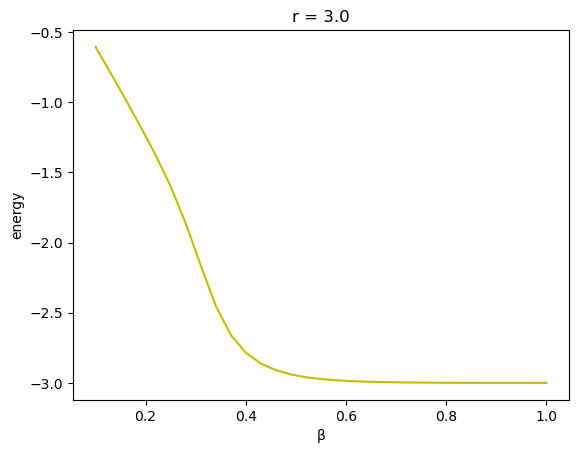

  8.902062 seconds (186.62 M allocations: 3.013 GiB, 8.27% gc time)


PyObject Text(24.000000000000007, 0.5, 'energy')

In [18]:
#test1
lattice = 8;               #晶格大小
Sweeps_heat = Int(1e4);       #热浴蒙卡次数
Sweeps = Int(1e6);           #蒙卡次数
βB = 0.1;                    #温度区间初始
βE = 1;                    #温度区间末尾
d = 0.03;                   #温度区间间隔
steps = Int(round((βE-βB)/d+1));
# mag_ave = zeros(steps,1);  
ene_ave = zeros(steps,1);
r = 3.0
@time begin
    Threads.@threads for i=1:steps
        β = βB+ d*(i-1);
        ene_ave[i] = MC(lattice,β,r,Sweeps_heat,Sweeps)
    end
end
β=βB:d:βE
# subplots_adjust(wspace=0.5)
# suptitle("r = $r")
# subplot(221)
# plot(β,mag_ave,"r")
# xlabel("β")
# ylabel("magnetic")

# subplot(222)
title("r = $r")
plot(β,ene_ave,"y")
xlabel("β")
ylabel("energy")

Starting point has λL1 = 0.2639787149186254 - 4.336849689150403e-9im ,λL2 =  0.2639787129537899 + 1.0258599525414525e-10im
                        λR1 = 0.26397871059882577 - 1.2432630203118578e-9im ,λR2 =  0.263978715305278 - 2.6764667769536366e-15im
Step 1: 
                                    λ1 * λ2 = 0.8173571739701083 + 2.432720691558643e-12im,
                                    λL1 = 0.8192794284506466 + 5.3013149425851225e-15im,
                                    λL2 = 0.8192794284506486 + 1.6653345369377348e-16im, 
                                    err1 ≈ 0.010443779409865727, 
                                    err2 ≈ 0.011036314122744688
Step 2: 
                                        λ1 * λ2 = 0.8196831549038528 + 1.6653345369377348e-16im,
                                        λL1 = 0.8196831547816235 - 5.069555886194621e-14im,
                                        λL2 = 0.8196831547816088 + 1.6653345369377348e-16im, 
                                        err1 ≈

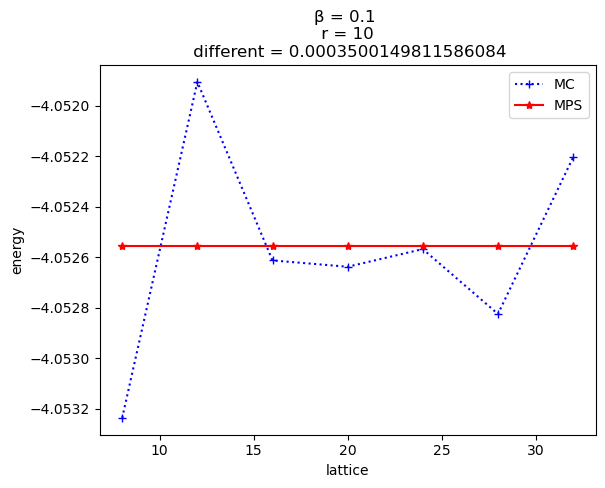

PyObject Text(0.5, 1.0, 'β = 0.1 \n r = 10 \n different = 0.0003500149811586084')

In [23]:
#test2
β= 0.1
# β = 0.1
r = 10
lB = 8;                    
lE = 32;                    
ld = 4;                    
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
Threads.@threads for i=1:steps
    lattice = lB+ ld*(i-1);
    eMC[i] = MC(lattice,β,r,Int(1e5),Int(1e6))
end

M1, M2, ME1, ME2, ME3, ME4,λM1,λM2 = classicalisingmpo(β; r = r)
D = 50
A1 = randn(D, 2, D) + im*randn(D, 2, D)
A2 = A1
λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4 = 
    vumps(A1,A2,M1,M2;tol = 1e-6,maxiter = 100)
eMPS = real(energy(M1, M2, ME1, ME2, ME3, ME4, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4,λM1,λM2))
different = abs(eMPS - eMC[steps])
lattice = lB:ld:lE
plot(lattice,reshape(eMC,steps,),"+:",color = "b",label = "MC")
plot(lattice,real(fill(eMPS,steps,1)),"*-",color = "r",label = "MPS")
legend(loc="best")
xlabel("lattice")
ylabel("energy")
title("β = $β \n r = $r \n different = $different")

In [17]:
@show 1.64*sqrt(var(eMC)/20) mean(eMC) - real(eMPS) mean(eMC) real(eMPS)

1.64 * sqrt(var(eMC) / 20) = 6.964584718860807e-5
mean(eMC) - real(eMPS) = -0.04123167665513261
mean(eMC) = -4.052562875683593
real(eMPS) = -4.011331199028461


-4.011331199028461

lattice  = 24 


Progress: 100%|█████████████████████████████████████████| Time: 0:35:30


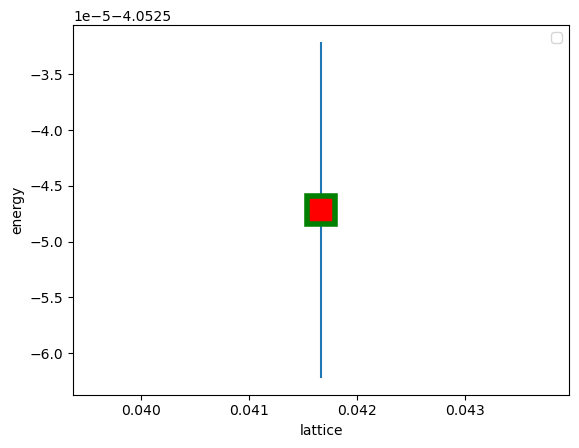

No handles with labels found to put in legend.


PyObject Text(24.000000000000007, 0.5, 'energy')

In [30]:
#test4 muti-data
β= 0.1
# β = 0.1
r = 10
lB = 24;                    
lE = 24;                    
ld = 4;
steps = Int(round((lE-lB)/ld+1));
eMC = zeros(steps,1)
err = zeros(steps,1)
Bins = 10
bins = 100
Sweeps_heat = Int(1e4)
Sweeps = Int(1e6)
for i=1:steps
    lattice = lB+ ld*(i-1);
    println("lattice  = $lattice ")
    eMC[i],err[i] = MutiMC(β,r,lattice,Bins,bins,Sweeps_heat,Sweeps)
end

lattice = lB:ld:lE
errorbar(1/lattice,reverse(reshape(eMC,steps,)),yerr = reverse(reshape(err,steps,)),marker="s", mfc="red",
                 mec="green", ms=20, mew=4)
legend(loc="best")
xlabel("lattice")
ylabel("energy")

### bond强度比例 r

r = 50
r = 90
r = 70
r = 0
r = 100
r = 10
r = 60
r = 20
r = 40
r = 30
r = 80


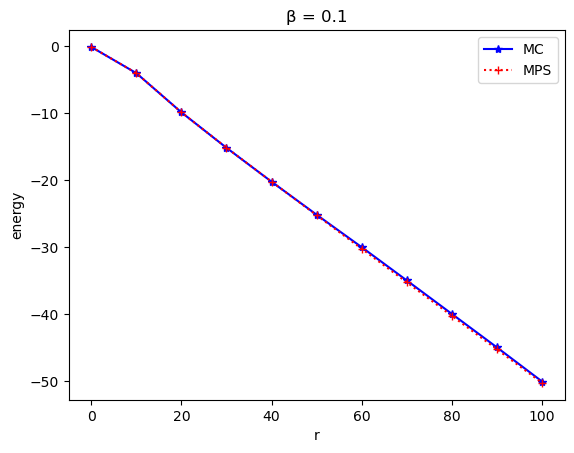

PyObject Text(0.5, 1.0, 'β = 0.1')

In [57]:
#full test change r
βc = log(1+sqrt(2))/2
β = 0.1
rB = 0;                    
rE = 100;                    
rd = 10;                    
steps = Int(round((rE-rB)/rd+1));
eMC = zeros(steps,1)
eMC_std = zeros(steps,1)
eMPS = zeros(steps,1)
lattice = 8
bins = 10
Threads.@threads for i=1:steps
    r = rB+ rd*(i-1);
    println("r = $r")
    M1, M2, ME1, ME2, ME3, ME4,λM1,λM2 = classicalisingmpo(β; r = r)
    D = 50
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    A2 = A1
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4 = 
        vumps(A1,A2,M1,M2;test = false,tol = 1e-12,maxiter = 100)
    eMPS[i] = real(energy(M1, M2, ME1, ME2, ME3, ME4, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4,λM1,λM2))
    eMC_bins = zeros(bins,1)
    for j = 1:bins
        eMC_bins[j] = MC(lattice,β,r,Int(1e3),Int(1e4))
    end
    eMC[i] = sum(eMC_bins) / bins
    eMC_std[i]= std(eMC_bins)
end
r = rB:rd:rE
plot(r,eMC,"*-",color = "b",label = "MC")
# plot(r,eMC_std,".:",color = "g",label = "MC_std")
plot(r,eMPS,"+:",color = "r",label = "MPS")
legend(loc="best")
xlabel("r")
ylabel("energy")
title("β = $β")

### 温度 β

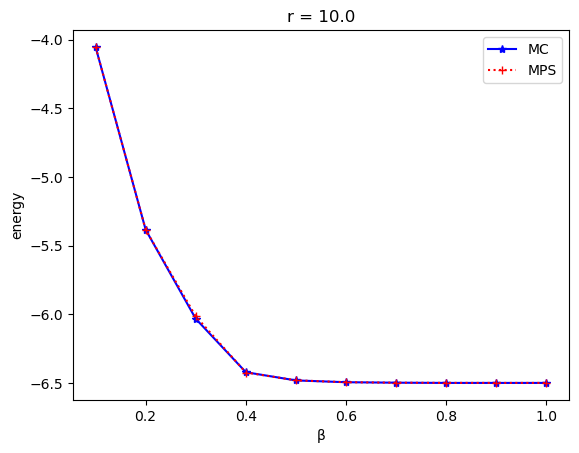

PyObject Text(0.5, 1.0, 'r = 10.0')

In [29]:
#full test change β
βc = log(1+sqrt(2))/2
βB = 0.1;                    
βE = 1;                    
βd = 0.1;  
r = 10.0
steps = Int(round((βE-βB)/βd+1));
eMC = zeros(steps,1)
eMPS = zeros(steps,1)
lattice = 32
Threads.@threads for i=1:steps
    β = βB+ βd*(i-1);
    M1, M2, ME1, ME2, ME3, ME4,λM1,λM2 = classicalisingmpo(β; r = r)
    D = 50
    Random.seed!(12345)
    A1 = randn(D, 2, D) + im*randn(D, 2, D)
    Random.seed!(12345)
    A2 = randn(D, 2, D) + im*randn(D, 2, D)
    λ1, λ2, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4 = 
        vumps(A1,A2,M1,M2;test = false,tol = 1e-12,maxiter = 100)
    eMPS[i] = real(energy(M1, M2, ME1, ME2, ME3, ME4, AL1, AL2, C1, C2, AR1, AR2, FL1, FL2, FL3, FL4, FR1, FR2, FR3, FR4,λM1,λM2))
    eMC[i] = MC(lattice,β,r,Int(1e4),Int(1e6))
end
β = βB:βd:βE
plot(β,eMC,"*-",color = "b",label = "MC")
plot(β,eMPS,"+:",color = "r",label = "MPS")
legend(loc="best")
xlabel("β")
ylabel("energy")
title("r = $r")